在開始之前, 先從 Kaggle 下載訓練以及測試用的資料:

```
kg download -u `user_name` -p `password` -c dogs-vs-cats-redux-kernels-edition
```

不過在下載之前, 必須先到 Kaggle 註冊帳號, 以及同意 Competition 的規則才能下載檔案:
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

Todo:
1. 建立實驗樣本(Sample)與驗證(Valid)目錄
2. 將 Kaggle 的檔案放置到符合 Keras 的目錄結構下
3. 載入 VGG16 model, finetune 以及重新對 dogs & cats 作訓練
4. 預測 Kaggle 的測試資料
5. 驗證測試結果
6. 在 Kaggle 上送交結果

## 建立實驗樣本與驗證目錄

In [1]:
%pwd
%matplotlib inline

In [2]:
import os, sys
current_dir = os.getcwd()
ROOT_PATH = current_dir
DATA_HOME_PATH = current_dir + '/data/redux'
DATA_HOME_PATH

'/home/paperspace/dogs-vs-cats-vgg16/data/redux'

In [3]:
import numpy as np
from numpy.random import permutation
from glob import glob
from shutil import copyfile
from PIL import Image
from utils import *

In [ ]:
%cd $DATA_HOME_PATH
%mkdir valid
%mkdir results
%mkdir sample
%mkdir -p sample/valid
%mkdir -p sample/train
%mkdir -p sample/test/unknown
%mkdir -p sample/results

In [ ]:
# 準備驗證資料

%cd $DATA_HOME_PATH/train
all_training_files = glob("*.jpg")

# 打亂檔案列表
shuffles = np.random.permutation(all_training_files)
if len(shuffles) > 0:
    # 取其中 2000 個檔案作為驗證資料用
    for i in range(0, 2000):
        os.rename(shuffles[i], DATA_HOME_PATH + '/valid/' + shuffles[i])

In [ ]:
# 為解省開發上時間的耗費, 會建立一個資料量相對小的 Sample 目錄, 程式開發完之後再轉移到完整的資料上
# 準備樣本的訓練資料
%cd $DATA_HOME_PATH/train
all_training_files = glob("*.jpg")

# 打亂檔案列表
shuffles = np.random.permutation(all_training_files)
if len(shuffles) > 0:
    # 取其中 200 個作為 Sample 的訓練資料
    for i in range(0, 200):
        copyfile(shuffles[i], DATA_HOME_PATH + '/sample/train/' + shuffles[i])

In [ ]:
# 準備樣本的驗證資料
%cd $DATA_HOME_PATH/valid

all_valid_files = glob("*.jpg")
shuffles = np.random.permutation(all_valid_files)
if len(shuffles) > 0:
    # 拿其中 50 個檔案作為 Sample 的驗證資料
    for i in range(0, 50):
        copyfile(shuffles[i], DATA_HOME_PATH + '/sample/valid/' + shuffles[i])

In [ ]:
# 準備樣本的測試資料
%cd $DATA_HOME_PATH/test
all_test_files = glob("*.jpg")
shuffles = np.random.permutation(all_test_files)
if len(shuffles) > 0:
    for i in range(0, 100):
        copyfile(shuffles[i], DATA_HOME_PATH + "/sample/test/unknown/" + shuffles[i])

## 將 Kaggle 的檔案放置到符合 Keras 的目錄結構下

Keras 的目錄結構用「類別」名稱作來命名子目錄, 從 Kaggle 下載下來的檔案則是用檔名的區分, 例如 cats.3111.jpg, 所以在這個步驟我們要建立 cats 跟 dogs 子目錄, 並將這些圖檔搬移到相對應的子目錄裡

In [ ]:
%cd $DATA_HOME_PATH/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
%cd $DATA_HOME_PATH/test
%mkdir unknown
%mv *.jpg unknown/

## 載入 VGG16 預先訓練好的模型, 只針對 dogs & cats 輸出

VGG16 是 Visual Geometry Group 的縮寫, 通常有分作 16 層跟 19 層 Neuon Network 的兩種版本, 它可以辨識 ImageNet 中 1500 個影像類別, 是個十分強大的 CNN 演算法, 網路上也可以下載預先訓練好的模型, 省下一開始找資料以及 training 上的時間, 可以直接拿來應用

不過原本的 VGG16 預先訓練好的模型的輸出有 1500 影像類別, 我們只需要 dogs 跟 cats 兩類, 所以我們必須將輸出類別限制在這兩類即可

In [24]:
%cd $ROOT_PATH

from vgg16 import Vgg16

path = DATA_HOME_PATH # + '/sample/'
valid_path = path + '/valid/'
train_path = path + '/train/'
test_path = path + '/test/'
result_path = path + '/results/'

/home/paperspace/dogs-vs-cats-vgg16


In [25]:
# 初始化 vgg 物件, 第一次初始會下載 Vgg16 pre-trained 的 weights, 下載檔案會放在 ~/.keras/models/
vgg = Vgg16()

In [26]:
batch_size = 4
epoch_num = 10

原本 Vgg16 model 可以偵測 1500 種類別, 但是在這裡我們只有兩種類別, 所以透過 Keras 的 finetune 機制將原本的 model mapping 到這兩種類別上

get_batches 會使用 Keras API - [Image Preprocessing](https://keras.io/preprocessing/image/), 從指定的目錄中批次將圖片讀出, 並對圖片作正規化, 每張圖片縮放成 244x244 大小

In [27]:
batches = vgg.get_batches(train_path, batch_size=batch_size)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.


接下來, 我們可以跑幾個 epoch 來 retrain model

In [ ]:
train_batches = vgg.get_batches(train_path, batch_size=batch_size)
train_history = vgg.fit(batches, train_batches, batch_size, nb_epoch=epoch_num)
latest_weights_filename = 'ft0.h5' 
vgg.model.save_weights(result_path + latest_weights_filename)

Found 23000 images belonging to 2 classes.
Epoch 1/10
5750/5750 [==============================] - 965s - loss: 0.8803 - acc: 0.8700 - val_loss: 0.5984 - val_acc: 0.9178
Epoch 2/10
5750/5750 [==============================] - 963s - loss: 1.0309 - acc: 0.8904 - val_loss: 0.6605 - val_acc: 0.9287
Epoch 3/10
1932/5750 [=========>....................] - ETA: 326s - loss: 1.0294 - acc: 0.9013

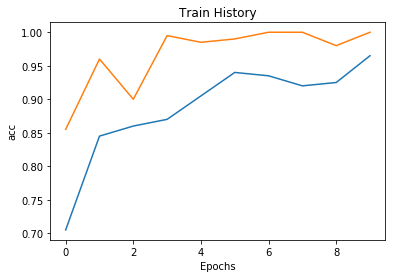

In [9]:
show_train_history(train_history, "acc", "val_acc")

## 測試

In [10]:
batches, probs = vgg.test(test_path, batch_size=batch_size)

Found 100 images belonging to 1 classes.


In [11]:
batches.filenames[:5]

['unknown/8640.jpg',
 'unknown/5162.jpg',
 'unknown/10765.jpg',
 'unknown/683.jpg',
 'unknown/358.jpg']

In [12]:
np.set_printoptions(suppress=True, precision=4)
print(probs[:5])
preds = probs[:,0]
labels = np.round(1-preds)

[[ 1.      0.    ]
 [ 0.0001  0.9999]
 [ 0.0027  0.9973]
 [ 1.      0.    ]
 [ 0.0053  0.9947]]


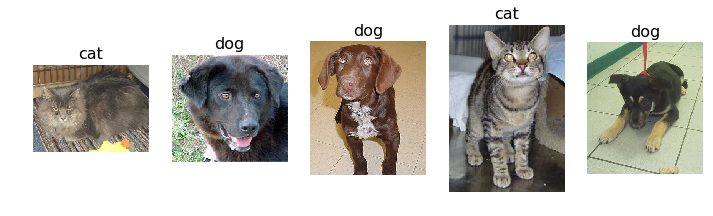

In [13]:
imgs = []
titles = []
idx = 0

for f in batches.filenames[:5]:
    img = Image.open(test_path + f)
    imgs.append(img)
    if labels[idx] == 0:
        titles.append("cat")
    else:
        titles.append("dog")
    idx = idx + 1
plots(imgs, titles=titles)

## 檢視結果

In [14]:
batches, probs = vgg.test(valid_path, batch_size=batch_size)

Found 50 images belonging to 2 classes.


In [15]:
filenames = batches.filenames
expected_labels = batches.classes
preds = probs[:, 0]
labels = np.round(1-preds)
print(labels)
print(expected_labels)

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


[ 0  1  2  4  5  6  7  8  9 10 11 12 13 15 16 17 20 21 22 23 24 25 26 27 28
 30 31 32 34 35 36 37 38 39 40 41 42 43 44 45 48 49]


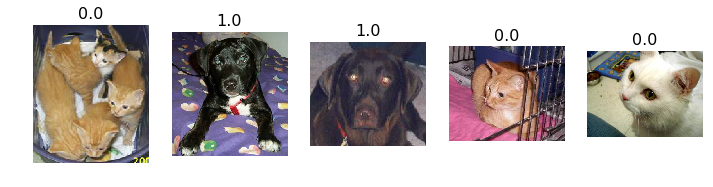

In [16]:
# 顯示正確判斷的圖片
correct = np.where(labels == expected_labels)[0]
print(correct)

plot_files(valid_path, correct, filenames, labels)

[ 3 14 18 19 29 33 46 47]


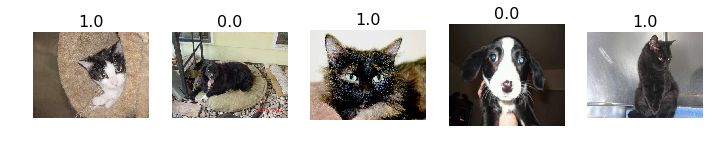

In [17]:
# 顯示錯誤判斷的圖片
incorrect = np.where(labels != expected_labels)[0]
print(incorrect)

plot_files(valid_path, incorrect, filenames, labels)

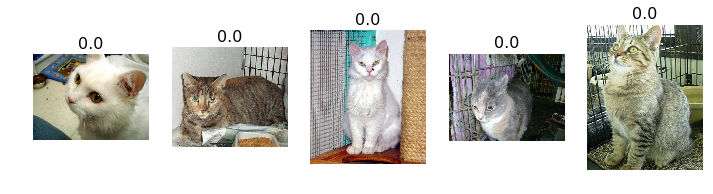

In [18]:
# 顯示正確判為貓咪的圖片
correct_cats = np.where((labels == expected_labels) & (labels == 0))[0]

plot_files(valid_path, correct_cats, filenames, labels)

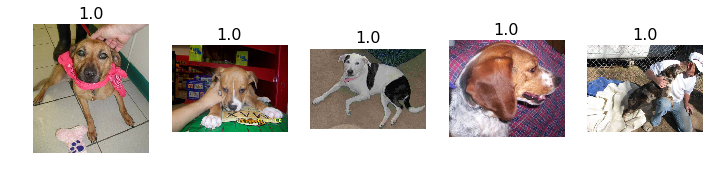

In [19]:
# 顯示正確判斷為狗狗的圖片
correct_dogs = np.where((labels == expected_labels) & (labels == 1))[0]

plot_files(valid_path, correct_dogs, filenames, labels)

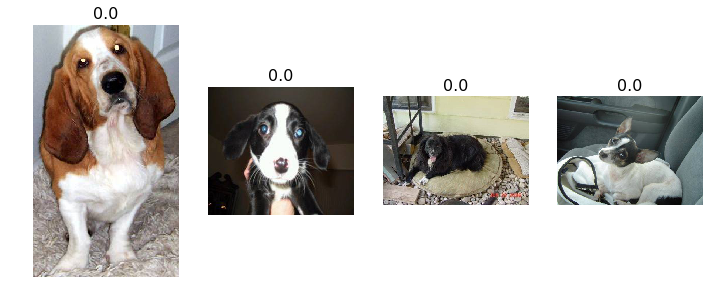

In [20]:
# 顯示貓咪誤判的圖片
incorrect_cats = np.where((labels != expected_labels) & (labels == 0))[0]

plot_files(valid_path, incorrect_cats, filenames, labels)

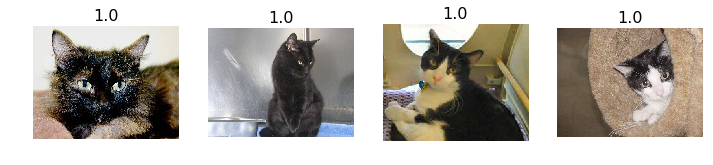

In [21]:
# 顯示狗狗誤判的圖片
incorrect_dogs = np.where((labels != expected_labels) & (labels == 1))[0]

plot_files(valid_path, incorrect_dogs, filenames, labels)

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, labels)

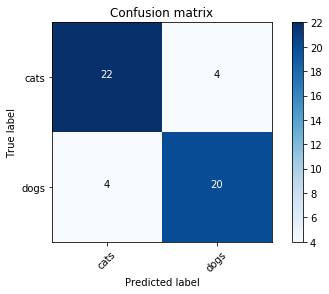

In [23]:
plot_confusion_matrix(cm, batches.class_indices)